# CDS

## Loading Libriaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading and Treating Data

In [2]:

# Load and clean data
file_path = "00.data/00.cds/credit_Default_Swap.xlsx"
df_cds_clean = pd.read_excel(file_path, sheet_name="CDS", skiprows=11)
df_cds_clean.rename(columns={df_cds_clean.columns[0]: "Date"}, inplace=True)
df_cds_clean["Date"] = pd.to_datetime(df_cds_clean["Date"], errors='coerce')
df_cds_clean = df_cds_clean.dropna(subset=["Date"])
country_map = {col: col for col in df_cds_clean.columns[1:]}


### Translating to English 

In [3]:
# Map for translating country names to English
country_translation = {
    'África do Sul': 'South Africa',
    'Alemanha': 'Germany',
    'Argentina': 'Argentina',
    'Austrália': 'Australia',
    'Áustria': 'Austria',
    'Bélgica': 'Belgium',
    'Brasil': 'Brazil',
    'Bulgária': 'Bulgaria',
    'Chile': 'Chile',
    'China': 'China',
    'Colômbia': 'Colombia',
    'Espanha': 'Spain',
    'França': 'France',
    'Grécia': 'Greece',
    'Irlanda': 'Ireland',
    'Itália': 'Italy',
    'Japão': 'Japan',
    'Coréia do Sul': 'South Korea',
    'México': 'Mexico',
    'Peru': 'Peru',
    'Portugal': 'Portugal',
    'Reino Unido': 'United Kingdom',
    'Rússia': 'Russia',
    'Tailândia': 'Thailand',
    'Venezuela': 'Venezuela',
    'Indonésia': 'Indonesia',
    'Polônia': 'Poland',
    'Hungria': 'Hungary',
    'Turquia': 'Turkey',
    'Ucrânia': 'Ukraine',
    'Croácia': 'Croatia'
}
# Rename columns using the translation map
df_cds_clean_english = df_cds_clean.copy()
# Rename columns using the translation map
df_cds_clean_english.rename(columns=country_translation, inplace=True)

## Países da amostra

In [4]:
# Filter and rename columns
selected = ['Brasil', 'África do Sul', 'México', 'Tailândia', 'Indonésia',
            'Chile','Filipinas','Vietnã' ,'Peru', 'Colômbia','Turquia','China','Coréia do Sul']#, 'Argentina']


selected_cols = {k: v for k, v in country_map.items() if v in selected}
df_emerging = df_cds_clean[['Date'] + list(selected_cols.keys())].copy()
df_emerging.rename(columns=selected_cols, inplace=True)


## Calculando médias entre os meses e subtraíndo 

Nesta chunck alterar a data conforme a necessidade. Alterar variáveis 'mes_inicio' e 'mes_fim' conofrme o interesse.

In [5]:
mes_inicio1 = '2024-12'
mes_fim1 = "2025-09"

In [6]:

df_filtered = df_emerging.set_index("Date")
mes_inicio = df_filtered.loc[mes_inicio1].mean()
mes_fim = df_filtered.loc[mes_fim1].mean()
cds_variation = (mes_fim - mes_inicio).dropna().sort_values(ascending=False)
cds_variation_df = cds_variation.reset_index()
cds_variation_df.columns = ['Country', 'CDS Variation (bps)']


## Gráfico

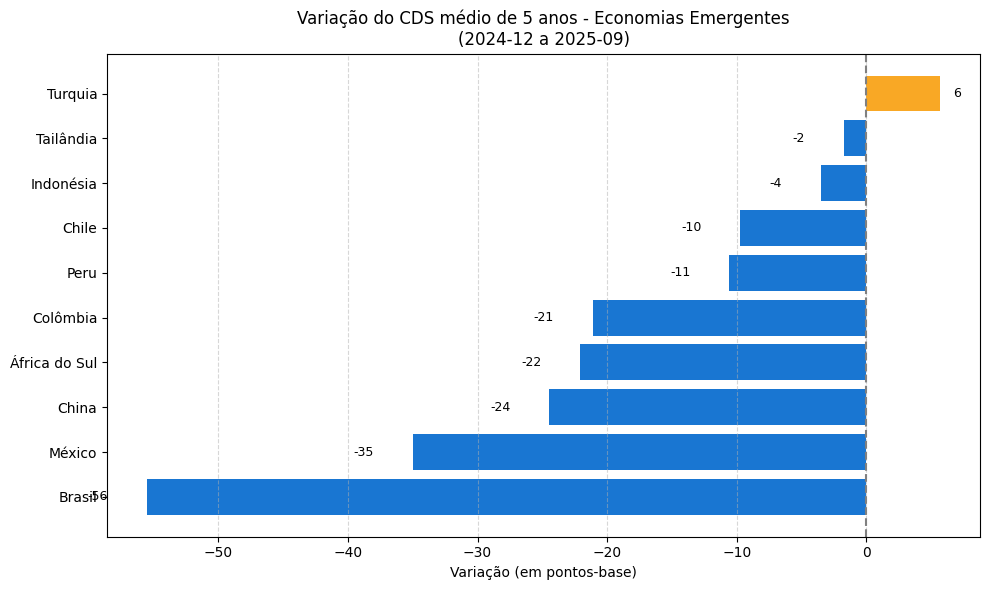

In [7]:

# Plot
colors = ['#F9A825' if x > 0 else '#1976D2' for x in cds_variation_df['CDS Variation (bps)']]
plt.figure(figsize=(10, 6))
bars = plt.barh(cds_variation_df['Country'], cds_variation_df['CDS Variation (bps)'], color=colors)
plt.axvline(x=0, color='gray', linestyle='--')
for bar in bars:
    width = bar.get_width()
    plt.text(width + (1 if width > 0 else -3), bar.get_y() + bar.get_height()/2,
             f'{width:.0f}', va='center', ha='left' if width > 0 else 'right', fontsize=9)
plt.title(f'Variação do CDS médio de 5 anos - Economias Emergentes\n({mes_inicio1} a {mes_fim1})', fontsize=12)
plt.xlabel('Variação (em pontos-base)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


## Salvando dados em Excel

In [8]:

# Save data
output_path = "00.data/00.cds/variacao_cds_medio_emergentes.xlsx"
cds_variation_df.to_excel(output_path, index=False)

output_path

'00.data/00.cds/variacao_cds_medio_emergentes.xlsx'